# Estimacion tiempo por vuelta de clasificación F1

## Descripción del modelo y de sus variables

Todos los datos recogidos son de las vueltas de clasificación de Q3 de las temporadas 2017, 2018 y 2019 del piloto de Fórmula 1 Max Verstappen del equipo Red Bull. Estos han sido recolectados por nosotros de varias fuentes. Primero recolectamos los datos de todas las vueltas de clasificación en las 3 temporadas para cada uno de los circuitos. Los datos sobre asphalt abrasion, grip y demás los obtuvimos de los datos de Pirelli para cada carrera en cada una de las temporadas; aunque por lo general no cambiaran. Para los datos de las curvas se analizó la telemetría de cada una de las vueltas de clasificación analizando cómo se hacían las curvas y utilizamos los criterios que más tarde explicamos.

Decidimos escoger a este piloto ya que era de los pocos pilotos que no habían cambiado de equipo recientemente para la temporada 2017 y no cambian de equipo desde entonces. Esto es importante debido a que así eliminamos la variación propia de conducir un coche que sea de otro equipo y las variaciones que esto conlleva.

Por ello este modelo sólo debe ser considerado para este piloto y este equipo, no como algo general.

### Variables finalmente empleadas

Hemos utilizado las siguientes variables para la construcción del modelo:

- **Longitud (Length)**: Longitud del circuito en metros.
- **Curvas Lentas**: Número de curvas lentas en el circuito. Consideramos que una curva es lenta si el piloto la toma de 1ª a 3ª marcha ya menos de 100 km/h.
- **Curva Media**: Número de curvas de media velocidad en el circuito. Consideramos una curva de media velocidad si se toma de 4ª a 5ª e incluso 6ª si la velocidad es menor a 170km/h.
- **Curva Rápida**: Número de curvas rápidas en el circuito. Consideramos una curva rápida si se va a más de 170 km/h y la marcha utilizada es 6ª o mayor. Es importante resaltar que consideraremos que una curva es rápida si previamente hay que bajar marcha,frenar o impide ganar velocidad pese a estar acelerando. Este detalle hace que muchas "curvas" en los circuitos no las consideremos como tal ya que un monoplaza de estas características es capaz de tomarlas a fondo, por lo que las consideramos una recta. Esto hace que no coincidan el número total de curvas con el que se suele especificar en los mapas de los circuitos. Por ejemplo el circuito de Spielberg (Austria) se supone que tiene 10 curvas cuando para el modelo constan sólo 6.
- **Asphalt Grip**: Esta puntuación la tomamos de las oficiales que da Pirelli, el suministrador de neumáticos de la Fórmula 1. Se numera de 1 a 5 el como se agarra la rueda al asfalto. A mayor grip la rueda se agarrará más y como consecuencia de ello es más fácil tomar la curva. 
- **Asphalt Abrasion**: Esta puntuación también la publica Pirelli. Numera del 1 al 5 la capacidad de desgaste de las ruedas del asfalto. Si el asfalto es muy abrasivo puede hacer que las ruedas se sobrecalienten y hacer que el piloto no pueda tomar todas las curvas todo lo rápido que el quisiera.


## Primera aproximación

En un principio teníamos un único fichero Excel en el que recopilamos todos los datos iniciales de panel con los que íbamos a trabajar, pero al intentar cargar la base de datos nos daba fallos relacionados con el propio Excel y con el hecho de que fueran de panel. Por ello lo que lo primero que hicimos fue cambiar el formato de la base de datos a csv y cambiar la forma de importar los datos al  programa. Luego surgieron otros problemas con la forma de acceder a los datos, ya que Excel no exportó la base de datos con el formato de csv que la función utilizaba. Al final arreglamos el fichero csv para no tener que utilizar separadores alternativos.

En un principio los datos eran importados en formato String (debido a usar ',' como separador en vez de '.', así no los reconocía como número) por lo que no podía hacer cálculos con estos y daba error, lo que solucionamos rápidamente transformandolos de string a float con la llamada a `X.astype('float64')`.

Cuando empezamos a estimar el modelo nos dimos cuenta de los distintos problemas que podiamos tener, como era el de una multicolinealidad muy fuerte entre distintas variables de nuestra base de datos. Así que empezamos a calcular los VIFS, la matriz de correlaccion, etc.

Debido a todos estos problemas que iba sufriendo nuestro modelo, probamos con hacer modificaciones en las variables. Intentamos transformar algunas de ellas en log(), ir proponiendo nuevos modelos usando algunas variables y otras no, etc. Para intentar reducir la multicolinealidad, comprobamos durante 2 semanas distintos conjuntos de datos, hasta que nos dimos cuenta que el principal problema era la variable presupuesto, pese a ser la única que no tenía ninguna relación aparente con el resto. Eliminando esta variable obtuvimos el modelo que utilizaríamos finalmente. Todos estos cambios fueron los que generaron todos los archivos excel y csv que tenemos en la carpeta datos.

**Lista de variables**


In [1]:
import statsmodels.api as sm
import pandas as pd 
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import numpy as np

datos_f1=pd.read_csv('datos/Datos F1_noMulti.csv', header=0)
list(datos_f1.columns)

['Tiempo Qualy (milisegundos)',
 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'log(aa)',
 'log(cl)',
 'log(cm)',
 'log(cr)',
 'log(ag)',
 'A�o',
 'Race',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip']

Esta es nuestra primera aproximación al modelo en la que empleamos todas las variables medidas. Como podemos observar en los datos que nos ofrece el modelo OLS tenemos varias variables con significación individual lo cual también conlleva la significación global, es decir, que la estimación de estas variables no está en un intervalo en el que esté comprendido el 0. Esto se comprueba con que el pvalor es menor que nuestro alfa (0,05).
Sin embargo, si atendemos al número condición con el que determinaremos si hay multicolinealidad, es de 1.42e+08 cuando para ser aceptable en este caso ha de ser menor de 400 y siendo muy preocupante si es mayor de 900. Para tener en cuenta otro criterio calculamos el factor de inflación de la varianza (VIF) y tras esto decidimos establecer otro modelo que fuese capaz de solucionar este problema.

**Construcción del modelo**


In [2]:
lista = datos_f1[['Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'A�o',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip']]
 
X=lista
X = X.astype('float64')
y=datos_f1.values[:,0]
y = y.astype('float64')
mco2 = sm.OLS(y, sm.add_constant(X)).fit()

mco2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     25.77
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.80e-17
Time:                        16:32:04   Log-Likelihood:                -184.37
No. Observations:                  63   AIC:                             396.7
Df Residuals:                      49   BIC:                             426.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                          -3.809e+04   4.47e+04     -0.852      0.398   -1.28e+05    5.17e+04
Length (m)                                        11.4177      1.921      5.942      0.000       7.556      15.279
Curva lenta                                        2.9419      0.518      5.683      0.000       1.902       3.982
Curva media                                       -2.1852      0.795     -2.748      0.008      -3.783      -0.587
Curva rapida                                       0.7530      0.503      1.498      0.141      -0.257       1.763
Presupuesto (mill. Euros)                          0.2370      0.261      0.909      0.368      -0.287       0.761
Asphalt Abrasion                                  -3.0421      0.955     -3.185      0.003      -4.961      -1.123
A�o                                               18.8477     22.105      0.853      0.398     -25.574      63.269
procentaje de tiempo con el acelerador a fondo    -0.0915      0.061     -1.505      0.139      -0.214       0.031
porcentaje de tiempo de frenada                   -0.1015      0.334     -0.304      0.762      -0.773       0.570
Downforce                                         -0.3179      1.367     -0.233      0.817      -3.065       2.429
Tyre Stress                                       -1.4723      1.209     -1.218      0.229      -3.902       0.957
Lateral energy                                     1.3061      1.324      0.987      0.329      -1.354       3.967
Asphalt Grip                                       4.1089      1.569      2.619      0.012       0.957       7.261
==============================================================================
Omnibus:                       33.520   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.034
Skew:                           1.730   Prob(JB):                     8.39e-17
Kurtosis:                       7.029   Cond. No.                     1.42e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Comprobación de los VIF**

Un VIF es un problema si es mayor que 10 y en nuestra primera aproximación tenemos variables con VIF que llegan a 500, lo que secunda nuestra hipótesis de que la multicolinealidad era un problema serio de nuestro primer modelo.

In [3]:
import statsmodels.stats.outliers_influence as oi
# Factor de inflacion de la varianza, con el for hacemos que salga  para toda las variables
vifs=[oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vifs

[243.79488635679184,
 20.450121603310286,
 50.59305334128654,
 11.277173922585359,
 25.93873672686255,
 16.69933010291783,
 528.0823516925276,
 29.82501279631423,
 56.16070940892564,
 50.684848326650645,
 37.961666726387165,
 47.731304211696745,
 47.58616355014205]

**Matriz de correlación**

Para poder ver de una forma mas fácil imprimiamos cada vez que hacíamos un cambio en la estimación imprimiamos la matriz de correlaciones entre las variables, para así poder ir cambiando el modelo en función de eso.

Cuando veíamos que una variable tenía una relacion muy directa con otra probabamos antes de quitarla del modelo a aplicarle el logaritmo para ver si así reducía la multicolinealidad, aunque esta solución pocas veces era efectiva probamos con bastantes variables para así solo eliminarlas en caso de haber descartado el resto de opciones.

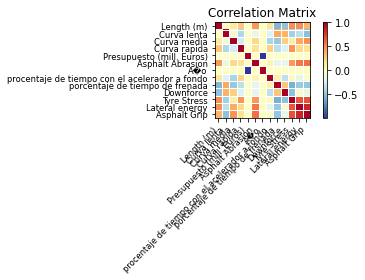

In [4]:
corr_matrix=np.corrcoef(X.T)

import statsmodels.graphics.api as smg
import matplotlib.pylab as plt

smg.plot_corr(corr_matrix, xnames=['Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'A�o',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip'])
plt.show()

## Modelo final

Basándonos en los VIF del anterior modelo fuimos eliminando variables según los nuevos resultados de VIF que obtuviesemos, hasta alcanzar un número condición lo suficientemente bajo sin sufrir penalizaciones en nuestro $R^2$.

In [5]:
lista = datos_f1[[ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']]

 
X=lista
X = X.astype('float64')
y=datos_f1.values[:,0]
y = y.astype('float64')
mco1 = sm.OLS(y, sm.add_constant(X)).fit()

mco1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.78
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           2.85e-21
Time:                        16:32:05   Log-Likelihood:                -189.52
No. Observations:                  63   AIC:                             393.0
Df Residuals:                      56   BIC:                             408.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.6538      5.015      2.723      0.009       3.607      23.700
Length (m)          11.4054      0.978     11.661      0.000       9.446      13.365
Curva lenta          3.0251      0.343      8.808      0.000       2.337       3.713
Curva media         -1.4984      0.549     -2.728      0.008      -2.599      -0.398
Curva rapida         0.5889      0.400      1.472      0.147      -0.212       1.390
Asphalt Grip         4.1230      1.047      3.939      0.000       2.026       6.220
Asphalt Abrasion    -3.1871      0.880     -3.623      0.001      -4.949      -1.425
==============================================================================
Omnibus:                       32.534   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.414
Skew:                           1.651   Prob(JB):                     1.14e-16
Kurtosis:                       7.130   Cond. No.                         82.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nuestro nuevo modelo tiene un número condición de 82.5, que aparentemente no indica presencia de multicolinealidad. También tiene un $R^2$ de 0.85 y ajustado de 0.834. Por otro lado los valores de AIC y BIC son mejores para nuestro nuevo modelo.

### Multicolinealidad

Hemos tomado como criterio para resolver la multicolinealidad el número condición, por ello es posible que la matriz de correlación o algún VIF tomen valores preocupantes. Aun así esta matriz de correlaciones es más correcta que la que teníamos en un principio.

In [6]:
corr_matrix=np.corrcoef(X.T)
print(corr_matrix)

[[ 1.          0.00753052  0.13372822  0.29054151  0.36949531  0.46805826]
 [ 0.00753052  1.         -0.06111079 -0.39084757 -0.50398903 -0.12775327]
 [ 0.13372822 -0.06111079  1.         -0.24789618  0.4831656   0.22624666]
 [ 0.29054151 -0.39084757 -0.24789618  1.          0.18379252  0.17162219]
 [ 0.36949531 -0.50398903  0.4831656   0.18379252  1.          0.59086427]
 [ 0.46805826 -0.12775327  0.22624666  0.17162219  0.59086427  1.        ]]


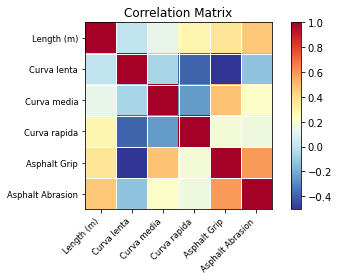

In [7]:
import statsmodels.graphics.api as smg
import matplotlib.pylab as plt
smg.plot_corr(corr_matrix, xnames=['Length (m)',
    'Curva lenta',
    'Curva media',
    'Curva rapida',
    'Asphalt Grip',
    'Asphalt Abrasion'])
plt.show()

### VIF

Al igual que con la matriz de correlación, los nuevos VIF son mejores que en el modelo anterior. Sin embargo, no hemos conseguido disminuir el factor de todas las variables, continuando varias en niveles preocupantes.

In [8]:
import statsmodels.stats.outliers_influence as oi
vifs=[oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vifs

[41.28812918135159,
 7.949618256746982,
 19.351884667157172,
 6.36234153030487,
 20.563114067024074,
 13.616582053542007]

### Heteroscedasticidad

Hemos realizado los tests de Goldfeld-Quandt, Breusch-Pagan y White donde sólo el primero de estos nos indica que existe un problema de heteroscedasticidad (varianzas diferentes para cada individuo). Esto se puede deber a que el test de Goldfeld-Quandt es para muestras pequeñas y las demás para muestras grandes. 
En nuestro caso tenemos 63 muestras, algo que no podemos clasificar sin lugar a dudas como una muestra grande o como una muestra pequeña. Por ello ante la duda decidimos hacer el test de Glejser y si hay algún problema arreglarlo tal y como indique este test.

In [9]:
GQ=sms.het_goldfeldquandt(mco1.model.endog, mco1.model.exog, split=3)
print('Het-Goldfelquandt', GQ)

BP=sms.het_breuschpagan(mco1.resid, mco1.model.exog)
print('Het-Breuschpagan', BP)

WH=sms.het_white(mco1.resid, mco1.model.exog)
print('Het-Whithe', WH) 

Het-Goldfelquandt (22.395983859110476, 8.91817819186668e-08, 'increasing')
Het-Breuschpagan (9.74808871156059, 0.13566929814691386, 1.7085238652767456, 0.13597834675774265)
Het-Whithe (20.702735884342026, 0.4148111973097286, 1.0278618786841114, 0.453548091635767)


### Glejser

Tal y como está programado el test de Glejser hacemos lo siguiente:
- En cada una de las variables comprobamos si hay relación lineal entre los residuos del modelo inicial y la variable elevada a -2, -1, -0.5, 0,5, 1, 2.
- A continuación debemos comprobar si su pvalor es menor que el alfa (de forma que confirme problema de heteroscedasticidad) y que su $R^2$ sea el máximo ya que es con el que nos quedaremos.

Los resultados nos indicaron que la variable $Asphalt Abrasion^2$ daba problemas de heteroscedasticidad por lo que decidimos estimar el modelo a través del modelo lineal ponderado por $\frac{1}{\sqrt{Asphalt Abrasion^2}}$, solucionando así los problemas de heteroscedasticidad.

In [10]:
headers = datos_f1.columns
header_maximo=""
alpha=0.05
h_max=0.0
r_max=0.0

elements = [ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']

for indice in elements:
    print(indice)
    z=datos_f1[indice]
    z = z.astype('float64')
    for h in [-2,-1,-0.5,0.5,1,2]:
        mcoaux=sm.OLS(abs(mco1.resid),sm.add_constant((z**h))).fit()
        pval=mcoaux.pvalues[1]
        r2=mcoaux.rsquared
        if((pval<alpha) and (r2>r_max)):
            r_max=r2
            header_max=indice
            h_max = h

print("La variable: " + header_max + " elevado a ", h_max, " daba problema de heteroscedasticidad")
z = datos_f1[header_max].astype('float64')
mcp = sm.WLS(y, sm.add_constant(X), weights=(1/np.sqrt(z**h_max))).fit()
mcp.summary()

Length (m)
Curva lenta
Curva media
Curva rapida
Asphalt Grip
Asphalt Abrasion
La variable: Asphalt Abrasion elevado a  2  daba problema de heteroscedasticidad


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            WLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     89.96
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           6.36e-27
Time:                        16:32:06   Log-Likelihood:                -181.22
No. Observations:                  63   AIC:                             376.4
Df Residuals:                      56   BIC:                             391.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.1570      3.549      3.426      0.001       5.048      19.266
Length (m)          11.9341      0.737     16.185      0.000      10.457      13.411
Curva lenta          2.7099      0.241     11.242      0.000       2.227       3.193
Curva media         -1.2861      0.478     -2.693      0.009      -2.243      -0.329
Curva rapida         0.2801      0.347      0.806      0.424      -0.416       0.976
Asphalt Grip         3.4334      0.973      3.529      0.001       1.484       5.382
Asphalt Abrasion    -2.3568      0.762     -3.094      0.003      -3.883      -0.831
==============================================================================
Omnibus:                       33.560   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.892
Skew:                           1.634   Prob(JB):                     3.68e-19
Kurtosis:                       7.654   Cond. No.                         68.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Autocorrelación

Observamos que en el test de Durbin-Watson nos da un número de 1.8402 siendo el teórico de apróximadamente (suponemos 65 muestras) dL=1.438 du= 1.767 por lo que está dentro del intervalo $1.767 < 1.8402 < 2.233$. 

Igualmente decidimos aplicar la solución iterativa de Cochrane-Orcutt hasta llegar a un valor de Durbin-Watson de 2.008.

In [11]:
from statsmodels.stats.stattools import durbin_watson
dw=durbin_watson(mcp.resid)
print("Durbin-Watson es ", dw)
rho= 1 - dw/2
mco_autocorr=sm.GLSAR(y, sm.add_constant(X), rho=rho)
res=mco_autocorr.iterative_fit(maxiter=100 , rtol=10**(-10))
res.summary()

Durbin-Watson es  1.8402520662727382


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                          GLSAR   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     47.94
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           4.26e-20
Time:                        16:32:06   Log-Likelihood:                -186.92
No. Observations:                  62   AIC:                             387.8
Df Residuals:                      55   BIC:                             402.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.3396      5.255      2.729      0.009       3.809      24.870
Length (m)          11.3766      1.025     11.094      0.000       9.322      13.432
Curva lenta          2.9910      0.359      8.342      0.000       2.272       3.710
Curva media         -1.5114      0.581     -2.602      0.012      -2.675      -0.347
Curva rapida         0.5559      0.420      1.325      0.191      -0.285       1.397
Asphalt Grip         4.0381      1.144      3.529      0.001       1.745       6.331
Asphalt Abrasion    -3.1645      0.947     -3.340      0.002      -5.063      -1.266
==============================================================================
Omnibus:                       33.875   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.989
Skew:                           1.728   Prob(JB):                     7.04e-18
Kurtosis:                       7.316   Cond. No.                         80.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linealidad

**Test Harvey-Collier**

El primer bloque de código trata de arreglar un problema que teníamos al intentar hacer el test de Harvey-Collier, ya que nos daba error en el skip a la hora de calcularlo. Al ejecutar la formula directamente nos encontrabamos este error, por lo que ejecutamos manualmente el código del test.Utilizamos un skip de 19 porque era el primero que no nos daba NaN como resultado.

Como nuestro pvalor es mayor que nuestra alfa no rechazamos la hipótesis nula (nuestro modelo se puede plantear como una ecuación lineal).

In [12]:
import statsmodels.stats.diagnostic as diagn

diagn.linear_harvey_collier(res, skip=19) # si nuestro alpha es menor que el p valor, hay linelidad, no se rechaza hipotesis nula

Ttest_1sampResult(statistic=nan, pvalue=nan)

In [13]:
from scipy import stats 
skip = 19 #len(res.params) bug in linear_harvey_collier
rr = sms.recursive_olsresiduals(res, skip=skip, alpha=0.95, order_by=None)
stats.ttest_1samp(rr[3][skip:], 0)

Ttest_1sampResult(statistic=1.8997565698072256, pvalue=0.06418508537169498)

**Test Reset de Ramsey**

Al igual que para el anterior como nuestro pvalor es mayor a nuestro alfa no rechazamos la hipótesis nula.

In [14]:
import statsmodels.stats.outliers_influence as oi
rr=oi.reset_ramsey(res, degree=2)
print (rr)

<F test: F=array([[0.27305626]]), p=0.6033875411755965, df_denom=55, df_num=1>


### Normalidad de los residuos

- Jarque-Bera: Test de hipótesis que contrasta si los datos de la muestra tienen el coeficiente de simetría y la curtósis de una distribución normal.
- $\chi^2$ (p-valor): p-valor del test de Jaque-Bera.
- Skew: Coeficiente de simetría de pearson de los residuos.
- Kurtosis: Coeficiente de apuntamiento de los residuos.
- Komogorov-Smirnov: test de hipótesis para contrastar si una muestra proviene de una distribución (en este caso normal).

In [15]:
import statsmodels.stats.api as sms
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
for i in range(4):
    print(name[i], test[i]) # para rechazar hipotesis nula de normalidad, tine que ser el pvlor mas chico que 0.05 nuestro alpha
                            # para que sea simetrica tiene que ser 0 la skew
                            # para que la kurtosis sea normal tiene que ser de 4

Jarque-Bera 76.76212656414955
Chi^2 two-tail prob. 2.1444504065430605e-17
Skew 1.6799857401403864
Kurtosis 7.23713423592888


Respecto a la normalidad de los residuos, mediante el test de chi^2 obtenemos un pvalor menor que nuestro alfa, por lo que no podemos asegurar que siga una distribución normal. Para ello también hemos recurrido a métodos gráficos: gráfica de los residuos y de los cuantiles. Observamos que la primera se asemeja vagamente a una normal y la segunda contiene muchos puntos por debajo de la línea roja, lo que también rechaza la normalidad. Además el coeficiente de Kurtosis nos sale 7, cuando debería estar entre 4 y 6.

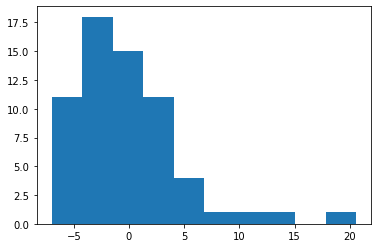

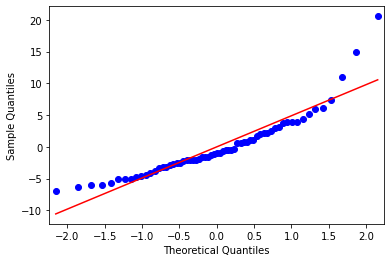

In [16]:
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

pyplot.hist(res.resid)
pyplot.show()
qqplot(res.resid, line='s')
pyplot.show()

In [17]:
import statsmodels.stats.diagnostic as diag

diag.kstest_normal(res.resid)

(0.13583628079337862, 0.00895822888898061)

Podemos observar como el pvalor del test de Komogorov-Smirnov indica que se rechaza la hipótesis nula, es decir, los residuos no siguen una distribución normal, lo que tiene una gran repercusión en el resultado de nuestro modelo.

## Predicciones sobre nuevos circuitos F1

### Circuito de Jeddah (Arabia Saudí)

Length (m) = 6174

Curva lenta = 2

Curva media = 2

Curva rapida = 4

Asphalt Grip = 3

Asphalt Abrasion = 2

In [18]:
valores = [1, 6174, 2, 2, 4, 3, 2]
tiempo = res.predict(valores)

print (tiempo , " y tenia que haber sido " , 87653)
print ( "Le ha faltado", 87653-tiempo, "se produce un acierto del ",(tiempo/87653)*100,"%")

[70264.69415331]  y tenia que haber sido  87653
Le ha faltado [17388.30584669] se produce un acierto del  [80.16233803] %


### Circuito de Losail (Qatar)

Length (m) = 5380

Curva lenta = 1

Curva media = 5

Curva rapida = 5

Asphalt Grip = 3

Asphalt Abrasion = 4

In [19]:
valores = [1, 5380, 1, 5, 5, 3, 4]
tiempo = res.predict(valores)

print (tiempo , " y tenia que haber sido " , 81478)
print ( "Le ha faltado", 81478-tiempo, "se produce un acierto del ",(tiempo/81478)*100,"%")

[61218.34214472]  y tenia que haber sido  81478
Le ha faltado [20259.65785528] se produce un acierto del  [75.13481203] %


### Circuito de Estambul (Turquía)

Length (m) = 5338

Curva lenta = 4

Curva media = 5

Curva rapida = 3

Asphalt Grip = 3

Asphalt Abrasion = 4

In [20]:
valores = [1, 5338, 4, 5, 3, 3, 4]
tiempo = res.predict(valores)

print (tiempo , " y tenia que haber sido " , 83196)
print ( "Le ha faltado", 83196-tiempo, "se produce un fallo del ",(tiempo/83196)*100,"%")

[60748.3845085]  y tenia que haber sido  83196
Le ha faltado [22447.6154915] se produce un fallo del  [73.01839573] %


## Conclusiones sobre el modelo

Respecto a las predicciones debemos tener en cuenta que el $R^2$ es bastante alto y que las predicciones observadas fallaban en un rango en torno al 25%. Estas predicciones serían poco significativas para el mundo del motorsport debido a su elevada precisión; aunque no consideramos que sea un modelo completamente erróneo.

Hemos acabado obteniendo un modelo homocedástico y sin autocorrelación ni multicolinealidad, sin embargo, hemos observado como se rechaza la normalidad de sus residuos a través del test de Komogorov-Smirnov. Por ello podemos concluir que no está planteado correctamente y debería ser rechazado al no cumplir con uno de los supuestos básicos (los residuos siguen una distribución normal de media 0 y varianza $\sigma^2 * I$). Esto hace que los $\beta$ no sigan una distribución normal y por ello no se pueda hacer inferencia, ni test de hipótesis fiables sobre la significación del modelo. Igual ocurre con la varianza, de la cual ya no podemos decir que siga una $\chi^2$ y por ello ser estimada.

### Posibles mejoras

El modelo se podría mejorar logrando variables más concisas como por ejemplo los metros de curva lenta, media y rápida más que el número de curvas ya que dependiendo de si hay más metros hay que perder más velocidad o menos. También podríamos obtener cuanta carga aerodinámica trasera o delantera tiene el coche. 

En general, conseguir variables más precisas (y que no son de dominio público) que nos permitan construir otro modelo con variables que quizás demuestren la normalidad de los residuos.